Assignment text  

In this assignment you generate ROC and Precision-Recall curves using the MNIST-C Data on a probability density based anomaly detection method of your choice.  
Specifically, you will:  

1) Get the MNIST and MNIST-C dataset.  
1) Select 3 different types of image corruption (e.g. canny edges) from MNIST-C.  
2) Create mixed datasets for training and test using the original MNIST and corrupted images at a 100/1 ratio for each corruption type. (so w/ 60,000 original MNIST train images, add in 600 of each corrupted type)  
3) Create a probability density based anomaly detector (doesn’t have to be from scratch).  
4) Using a range of probability thresholds, create the corresponding ROC and precision-recall curves.  
5) You will turn in both the code and a short report, discussing what you’ve implemented, how well it worked, what you’ve learned, etc. 

Remember, you must understand what you turn in – you may be asked to explain it to me and/or the class  

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import os
"""
    This cell contains the global variables used in the notebook and imports the necessary libraries.

    Returns:
    None
    """
#path global variables
mnist_data_downloaded = True
mnist_c_data_downloaded = True 

mnist_path = '\\..\\data\\mnist\\'
mnist_c_path = '\\..\\data\\mnist_c\\'
mnist_data = '\\..\\data\\mnist\\mnist_train_28x28.npy'
mnist_labels = '\\..\\data\\mnist\\mnist_train_labels_28x28.npy'

mnist_c_data_path = r'\..\data\mnist_c'

mnist_files_generated = True
mnist_c_files_generated = True
generate_corrupted_data = True
# The combined data set will have 60000 + 600 + 600 + 600 samples
N_corruptions = 3
# To complete the assignment, we will use the following values for N1, N2, N3, N4
N1 = 60000
N_corrupt = 600

#create N_anomaly to store N_corrupt for N_corruption elements
N_anomaly = np.ones(N_corruptions) * N_corrupt
N = [N1, N_anomaly.astype(int)]

#storage for k-nearest neighbors classifier data
knnc_test_scenarios = [3, 10, 30, 100, 300, 1000, 3000, 10000]
knnc_pred_y = []
knnc_proba = []

#storage for random forest classifier data
rf_test_scenarios = [3, 10, 30]
rf_pred_y = []
rf_proba = []


In [51]:
# data sets are located in the data folder
# For data source #1, we will be using the training set of MNIST data, called train_1_28_28.npy
# for data source #2, we will be using a training set of MNIST-C data, that will be chosen from the mnist-c data folder set
# for data source #3, we will be using a training set of MNIST-C data, that will be chosen from the mnist-c data folder set
# for data source #4, we will be using a training set of MNIST-C data, that will be chosen from the mnist-c data folder set

# the combined data set will be called assignment_6_mnist_c_data.npy
# From data source #1 we will use N1 samples
# From data source #2 we will use N2 samples
# From data source #3 we will use N3 samples
# From data source #4 we will use N4 samples

def process_data():
    """
    This function processes the data for the assignment.

    It loads the MNIST dataset if it is not already downloaded.
    It saves the data and labels to the data folder under the mnist folder.
    It reshapes the data to 28x28.
    It splits the data into training and testing sets.

    Returns:
    None
    """
    if not mnist_data_downloaded:
        #load mnist dataset
        mnist = fetch_openml('mnist_784')
        #load data and labels
        X = mnist.data
        y = mnist.target

        print(X.shape)
        print(y.shape)


    #save X and y to data folder under mnist folder as mnist_full_784.npy and mnist_full_labels_784.npy
    if not mnist_files_generated:
        if X is None or y is None:
            X = np.load(os.getcwd() + mnist_path + 'mnist_full_784.npy')
            y = np.load(os.getcwd() + mnist_path + 'mnist_full_labels_784.npy')

        X_npy = X.to_numpy()
        y_npy = y.to_numpy()

        np.save(os.getcwd() + mnist_path + 'mnist_full_784.npy', X_npy)
        np.save(os.getcwd() + mnist_path + 'mnist_full_labels_784.npy', y_npy)

        #reshape X to 28x28
        X_reshaped = X_npy.reshape(-1, 28, 28)
        np.save(os.getcwd() + mnist_path + 'mnist_full_28x28.npy', X_reshaped)

        #split data into training and testing
        X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_npy, train_size=N1, test_size=len(y_npy)-N1)
        np.save(os.getcwd() + mnist_path + 'mnist_train_28x28.npy', X_train)
        np.save(os.getcwd() + mnist_path + 'mnist_train_labels_28x28.npy', y_train)
        np.save(os.getcwd() + mnist_path + 'mnist_test_28x28.npy', X_test)
        np.save(os.getcwd() + mnist_path + 'mnist_test_labels_28x28.npy', y_test)

process_data()

In [52]:
"""
This code generates corrupted MNIST data and saves it to numpy arrays. 
If `generate_corrupted_data` is True, it generates the corrupted data and saves it to files. 
Otherwise, it loads the previously generated data from the files.

The code performs the following steps:
1. Generates a dictionary of the mnist-c classification folders located in the mnist-c data folder.
2. Removes non-folders from the list of folders.
3. Randomly selects N_corruptions number of folders from the list.
4. Creates arrays X and y with the appropriate shape to accept the data from the corrupted MNIST data.
5. Loops through the selected folders and loads the image and label files.
6. Randomly selects N_anomaly number of indexes from the label file.
7. Assigns the selected images and labels to the corresponding arrays in X_corrupt and y_corrupt.
8. Loads the original MNIST data from the specified file.
9. Combines the MNIST data with the corrupted data by concatenating the arrays.
10. Generates the labels for the anomaly detection problem.
11. Saves the generated data and labels to numpy files.

Parameters:
- generate_corrupted_data (bool): If True, generates the corrupted data. If False, loads the previously generated data.
- mnist_c_data_path (str): The path to the mnist-c data folder.
- N_corruptions (int): The number of corrupted data to generate.
- N_anomaly (list): A list of integers representing the number of anomalies to select from each corrupted data folder.
- mnist_data (str): The path to the original MNIST data file.

Returns:
- X (ndarray): The combined data array.
- y_mnist_class (ndarray): The labels for the combined data.
- y_anomaly (ndarray): The labels for the anomaly detection problem.
- choose_N_folders (ndarray): The selected folders from the mnist-c data.

"""

if generate_corrupted_data:
    #generate a dictionary of the mnist-c classification folders located in the mnist-c data folder
    folders = os.listdir(os.getcwd() + mnist_c_data_path)
    #remove non folders
    folders = [folder for folder in folders if os.path.isdir(os.getcwd() + mnist_c_data_path + '\\' + folder)]
    choose_N_folders = np.random.choice(folders,N_corruptions, replace=False)

    #create the arrays X and y that have the appropriate shape to accept the data from the corrupted MNIST data
    #shape for X_c is (N_corruptions, 600, 28, 28)
    #shape for y_c is (N_corruptions, 600)

    for i in range(int(N_corruptions)):
        X_i = np.array([np.zeros((int(N_anomaly[i]),28,28))])
        y_i = np.array([np.zeros(int(N_anomaly[i]))])
        if i == 0:
            X_corrupt = X_i
            y_corrupt = y_i
        else:
            X_corrupt = np.concatenate((X_corrupt, X_i))
            y_corrupt = np.concatenate((y_corrupt, y_i))
        

    for index, folder in enumerate(choose_N_folders):     
        image_file = os.getcwd() + mnist_c_data_path + '\\' + folder + r'\train_images.npy'
        label_file = os.getcwd() + mnist_c_data_path + '\\' + folder + r'\train_labels.npy'
        print(image_file)
        print(label_file)
        
        choose_indexes = np.random.choice(np.load(label_file).shape[0], int(N_anomaly[index]), replace=False)
        
        X_corrupt[index] = np.load(image_file)[choose_indexes][:,:,:,0]
        y_corrupt[index] = np.load(label_file)[choose_indexes]

    #load the MNIST data from ../data/mnist/train_1_28_28.npy  
    X_mnist = np.load(os.getcwd() + mnist_data)
    y_mnist = np.load(os.getcwd() + mnist_data.replace('train','train_labels'), allow_pickle=True)

    #generate the combined data set, randomly mix in the MNIST data with the MNIST-C data
    X = X_mnist
    y_mnist_class = y_mnist

    for i in range(int(N_corruptions)):    
        X = np.concatenate((X, X_corrupt[i]))
        y_mnist_class = np.concatenate((y_mnist_class, y_corrupt[i].astype(int).astype(str)))
        
    #y_anomaly is the labels for the anomaly detection problem, the original y labels are used for other purposes
    #y_anomaly labels are generated as follows: data from mnist is labeled as 0, data from mnist-c is labeled as 
    y_anomaly = np.concatenate((np.zeros(N1), np.ones(int(N_anomaly.sum())))).astype(int)

    np.save(os.getcwd() + mnist_path + '..\\' + 'assignment_6_mnist_c_data.npy', X)
    np.save(os.getcwd() + mnist_path + '..\\' +'assignment_6_mnist_c_labels.npy', y_mnist_class)
    np.save(os.getcwd() + mnist_path + '..\\' +'assignment_6_mnist_c_anomaly_labels.npy', y_anomaly)
    np.save(os.getcwd() + mnist_path + '..\\' +'assignment_6_mnist_c_anomaly_classes.npy', choose_N_folders)
else:
    X = np.load(os.getcwd() + mnist_path + '..\\' + 'assignment_6_mnist_c_data.npy')
    y_mnist_class = np.load(os.getcwd() + mnist_path + '..\\' +'assignment_6_mnist_c_labels.npy')
    y_anomaly = np.load(os.getcwd() + mnist_path + '..\\' +'assignment_6_mnist_c_anomaly_labels.npy')
    choose_N_folders = np.load(os.getcwd() + mnist_path + '..\\' +'assignment_6_mnist_c_anomaly_classes.npy')



h:\dev\git\csc730\assignment 6\..\data\mnist_c\shear\train_images.npy
h:\dev\git\csc730\assignment 6\..\data\mnist_c\shear\train_labels.npy
h:\dev\git\csc730\assignment 6\..\data\mnist_c\canny_edges\train_images.npy
h:\dev\git\csc730\assignment 6\..\data\mnist_c\canny_edges\train_labels.npy
h:\dev\git\csc730\assignment 6\..\data\mnist_c\spatter\train_images.npy
h:\dev\git\csc730\assignment 6\..\data\mnist_c\spatter\train_labels.npy


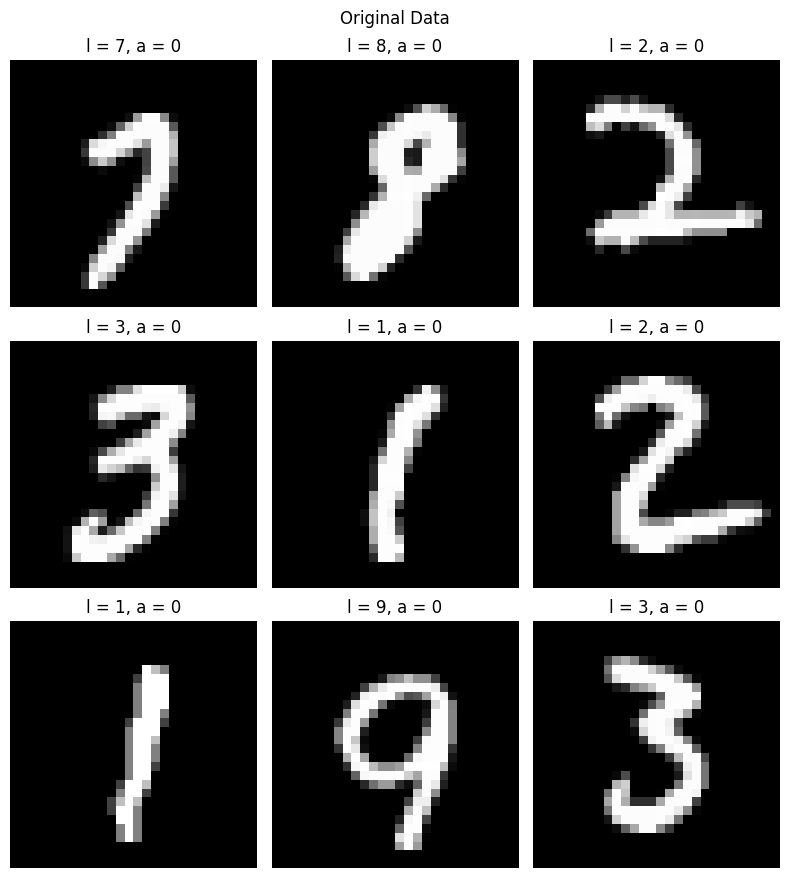

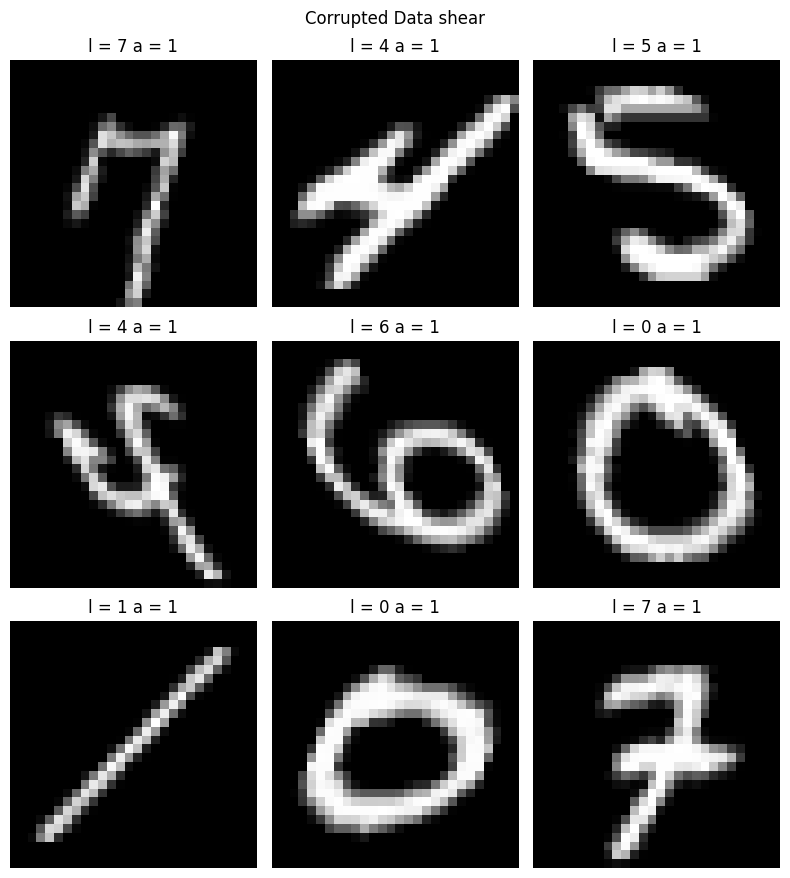

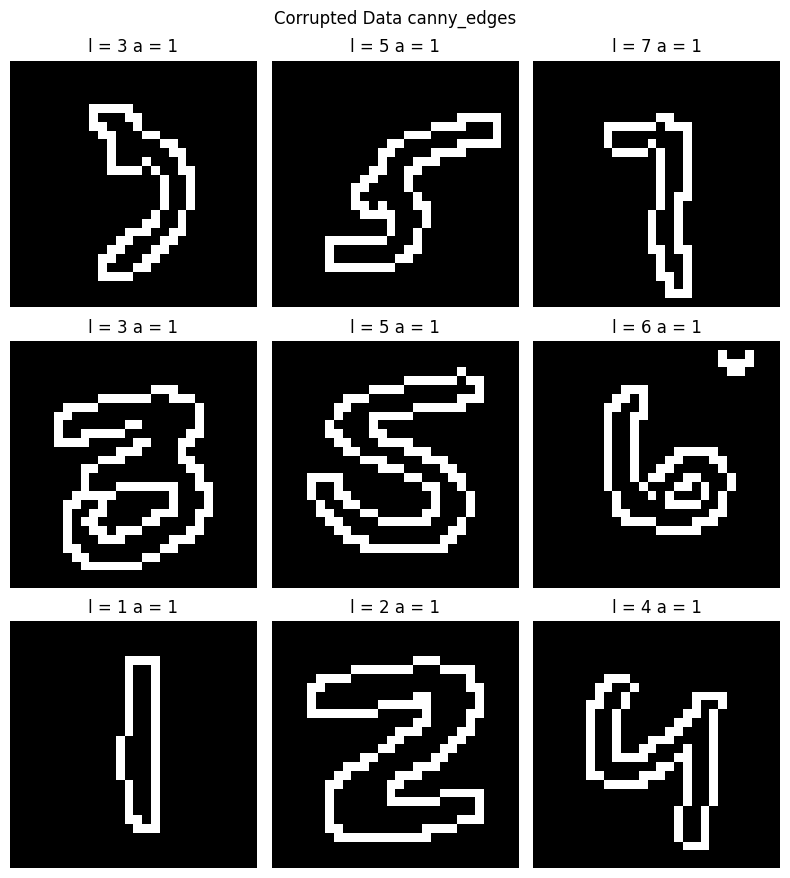

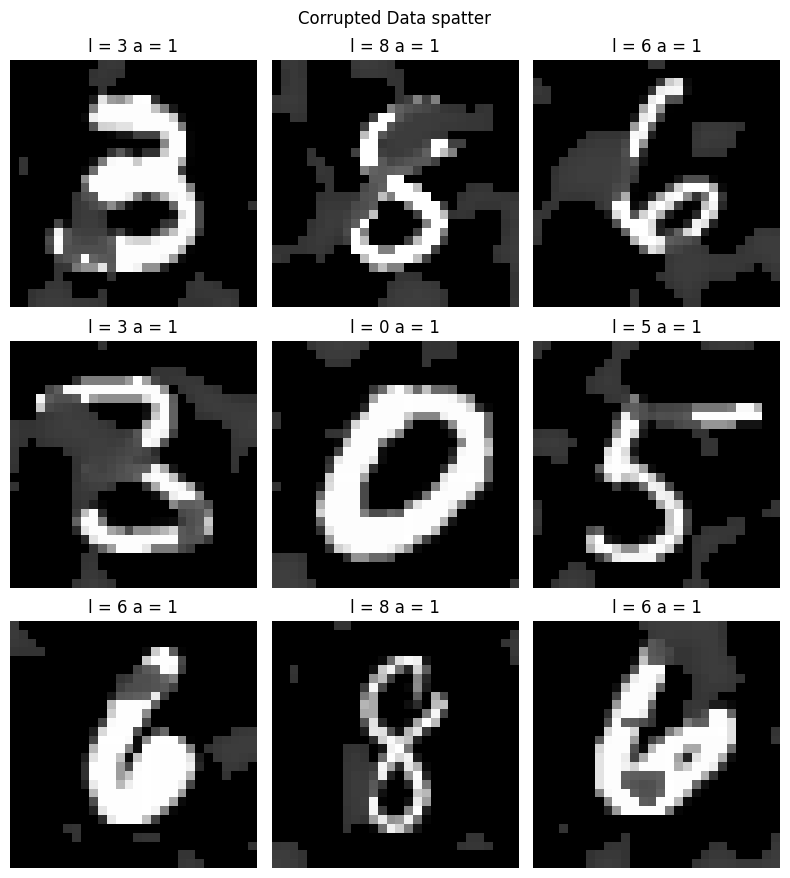

In [53]:
#test the data by loading it, and plotting 10 images between 0 and 59999, and 10 images between 60000 and 60599, and 10 images between 60600 and 61199, and 10 images between 61200 and 61799
#the images will plotted as a 28x28 image and the plot will be labeled with the class of image and the anomaly label
#load the data
X = np.load(os.getcwd() + mnist_path + '..\\' + 'assignment_6_mnist_c_data.npy')
y = np.load(os.getcwd() + mnist_path + '..\\' +'assignment_6_mnist_c_labels.npy', allow_pickle=True)
y_anomaly = np.load(os.getcwd() + mnist_path + '..\\' +'assignment_6_mnist_c_anomaly_labels.npy')

#original data plots, in subplot that is 1 row and 10 columns
row = 3
col = 3
fig, ax = plt.subplots(row, col, figsize=(8,9))
plt.suptitle('Original Data')
for i in range(9):
    ax[int(i/row)][int(i%col)].imshow(X[i], cmap='gray')
    ax[int(i/row)][int(i%col)].set_title(f'l = {y[i]}, a = {y_anomaly[i]}')
    ax[int(i/row)][int(i%col)].axis('off')   
plt.tight_layout()    
plt.savefig(os.getcwd() + f'\\report\\resource\\original_data.png')
plt.show()

for corrupt_index in range(N_corruptions):
    fig, ax = plt.subplots(row, col, figsize=(8,9))
    plt.suptitle(f'Corrupted Data {choose_N_folders[corrupt_index]}')
    for i in range(9):
        ax[int(i/row)][int(i%col)].imshow(X[N1 + corrupt_index*N_corrupt + i], cmap='gray')
        ax[int(i/row)][int(i%col)].set_title(f'l = {y[N1 + corrupt_index*N_corrupt + i]} a = {y_anomaly[N1 + corrupt_index*N_corrupt + i]}')
        ax[int(i/row)][int(i%col)].axis('off')    
    plt.tight_layout()
    plt.savefig(os.getcwd() + '\\report\\resource\\' + f'corrupted_data_{choose_N_folders[corrupt_index]}.png')
    plt.show()




In [54]:

#generate a probability density based anomaly detection model
#load the data
#split into training and testing
X = np.load(os.getcwd() + mnist_path + '..\\' + 'assignment_6_mnist_c_data.npy')
X_784 = X.reshape(-1, 28*28)
y = np.load(os.getcwd() + mnist_path + '..\\' +'assignment_6_mnist_c_labels.npy', allow_pickle=True)
y_anomaly = np.load(os.getcwd() + mnist_path + '..\\' +'assignment_6_mnist_c_anomaly_labels.npy')

X_train, X_test, y_train, y_test = train_test_split(X_784, y_anomaly, train_size=0.8, test_size=0.2)

#print statistics of training and testing data
print(f'Training data has {X_train.shape[0]} samples')
print(f'Testing data has {X_test.shape[0]} samples')
print(f'Training data has {y_train[y_train == 0].shape[0]} normal samples' + f' and {y_train[y_train == 1].shape[0]} anomaly samples')
print(f'Testing data has {y_test[y_test == 0].shape[0]} normal samples' + f' and {y_test[y_test == 1].shape[0]} anomaly samples')

for knnc_test in knnc_test_scenarios:
    print(f'KNNC test scenario: {knnc_test}')
    knnc = KNeighborsClassifier(n_neighbors=knnc_test)
    knnc.fit(X_train, y_train)
    knnc_pred_y.append(knnc.predict(X_test))
    knnc_proba.append( knnc.predict_proba(X_test))
    

#random forest classifier
for rf_test in rf_test_scenarios:
    print(f'Random Forest test scenario: {rf_test}')
    rf = RandomForestClassifier(n_estimators=rf_test)
    rf.fit(X_train, y_train)
    rf_pred_y.append(rf.predict(X_test))
    rf_proba.append(rf.predict_proba(X_test))



Training data has 49440 samples
Testing data has 12360 samples
Training data has 48009 normal samples and 1431 anomaly samples
Testing data has 11991 normal samples and 369 anomaly samples
KNNC test scenario: 3


h:\dev\git\csc730\assignment 6\.venv\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


KNNC test scenario: 10


h:\dev\git\csc730\assignment 6\.venv\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


KNNC test scenario: 30


h:\dev\git\csc730\assignment 6\.venv\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


KNNC test scenario: 100


h:\dev\git\csc730\assignment 6\.venv\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


KNNC test scenario: 300


h:\dev\git\csc730\assignment 6\.venv\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


KNNC test scenario: 1000


h:\dev\git\csc730\assignment 6\.venv\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


KNNC test scenario: 3000


h:\dev\git\csc730\assignment 6\.venv\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


KNNC test scenario: 10000


h:\dev\git\csc730\assignment 6\.venv\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Random Forest test scenario: 3
Random Forest test scenario: 10
Random Forest test scenario: 30


C:\Users\krisr\AppData\Local\Temp\ipykernel_19552\3407178247.py:54: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\krisr\AppData\Local\Temp\ipykernel_19552\3407178247.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


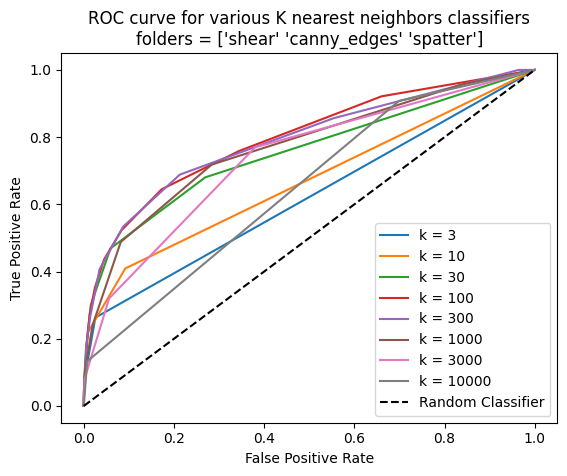

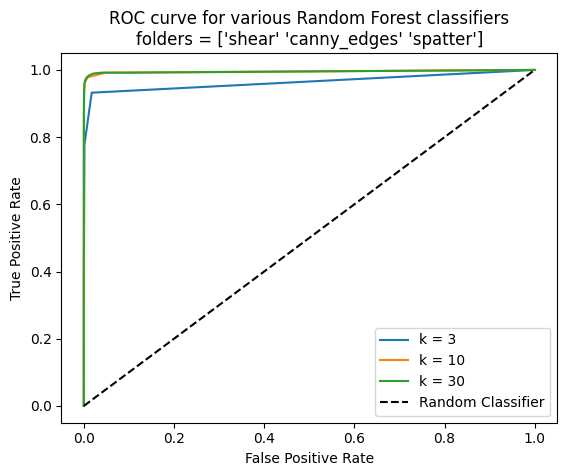

In [55]:
import numpy as np
import matplotlib.pyplot as plt

def generate_roc_curve(knnc_test_scenarios, knnc_proba, y_test, choose_N_folders):
    """
    Generate ROC curve for various K nearest neighbors classifiers.

    Parameters:
    - knnc_test_scenarios (list): List of K nearest neighbors test scenarios.
    - knnc_proba (numpy.ndarray): Array of predicted probabilities for each test scenario.
    - y_test (numpy.ndarray): Array of true labels for the test data.
    - choose_N_folders (list): List of chosen N folders.

    Returns:
        fig (matplotlib.figure.Figure): The figure object.
        ax (matplotlib.axes._subplots.AxesSubplot): The axis object.
    """
    # Generate the thresholds
    tpr = np.zeros((len(knnc_test_scenarios), 100))
    fpr = np.zeros((len(knnc_test_scenarios), 100))
    thresholds = np.array(np.histogram(knnc_proba[0][:,-1], bins=98)[1])
    thresholds = np.append(thresholds, thresholds[-1]+1)  

    fig, ax = plt.subplots()
    for test_index, knnc_test in enumerate(knnc_test_scenarios):    
        for i, threshold in enumerate(thresholds):
            y_test_pred = knnc_proba[test_index] > threshold
            
            if np.sum(y_test==1) == 0:
                tpr[test_index][i] = 0
                fpr[test_index][i] = np.sum((y_test == 0) & (y_test_pred[:,-1] == 1)) / np.sum(y_test == 0)
            elif np.sum(y_test==0) == 0:
                tpr[test_index][i] = np.sum((y_test == 1) & (y_test_pred[:,-1] == 1)) / np.sum(y_test == 1)
                fpr[test_index][i] = 1            
            else:            
                tpr[test_index][i] = np.sum((y_test == 1) & (y_test_pred[:,-1] == 1)) / np.sum(y_test == 1)
                fpr[test_index][i] = np.sum((y_test == 0) & (y_test_pred[:,-1] == 1)) / np.sum(y_test == 0)

        ax.plot(np.append(1,fpr[test_index]), np.append(1,tpr[test_index]), label=f'k = {knnc_test_scenarios[test_index]}')

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    
    #plt.title(f'ROC curve for various K nearest neighbors classifiers\nfolders = {choose_N_folders}')

    # Add a random classifier line to the plot, slope = 1, intercept = 0
    ax.plot([0,1],[0,1], linestyle='--', color='black', label='Random Classifier')
    ax.legend()
    # plt.savefig('roc_curve_' + '_'.join(choose_N_folders) + '.png')
    return fig, ax

fig, ax = generate_roc_curve(knnc_test_scenarios, knnc_proba, y_test, choose_N_folders)
ax.set_title(f'ROC curve for various K nearest neighbors classifiers\nfolders = {choose_N_folders}')
fig.savefig(os.getcwd() + '\\report\\resource\\' + 'roc_curve_knn_' + '_'.join(choose_N_folders) + '.png')
fig.show()

fig, ax = generate_roc_curve(rf_test_scenarios, rf_proba, y_test, choose_N_folders)
ax.set_title(f'ROC curve for various Random Forest classifiers\nfolders = {choose_N_folders}')
fig.savefig(os.getcwd() + '\\report\\resource\\' + 'roc_curve_rf_' + '_'.join(choose_N_folders) + '.png')
fig.show()


C:\Users\krisr\AppData\Local\Temp\ipykernel_19552\1228917917.py:37: RuntimeWarning: invalid value encountered in scalar divide
  precision[test_index][i] = np.sum((y_test == 1) & (y_test_pred[:,-1] == 1)) / np.sum(y_test_pred[:,-1] == 1)
C:\Users\krisr\AppData\Local\Temp\ipykernel_19552\1228917917.py:54: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\krisr\AppData\Local\Temp\ipykernel_19552\1228917917.py:59: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


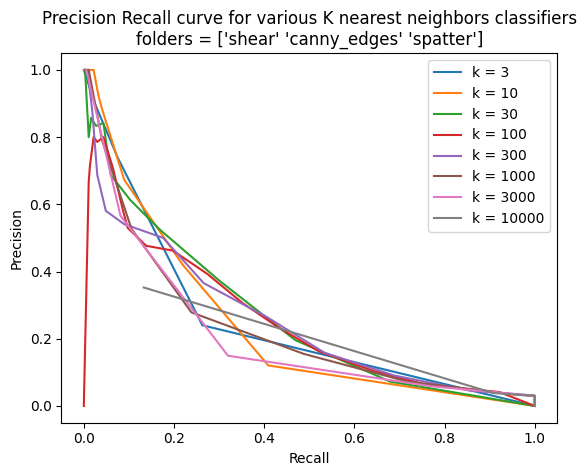

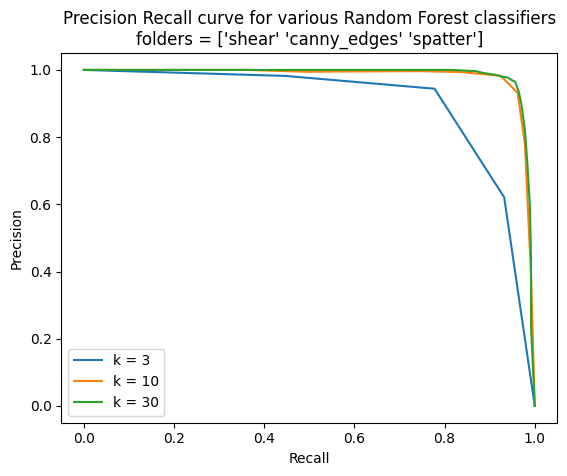

In [56]:

import numpy as np
import matplotlib.pyplot as plt

def generate_precision_recall_curve(knnc_test_scenarios, knnc_proba, y_test, choose_N_folders):
    """
    Generate precision and recall curve from scratch.

    Args:
        knnc_test_scenarios (list): List of k values for K nearest neighbors classifiers.
        knnc_proba (numpy.ndarray): Array of predicted probabilities from K nearest neighbors classifiers.
        y_test (numpy.ndarray): Array of true labels for the test data.
        choose_N_folders (list): List of folder names.

    Returns:
        fig (matplotlib.figure.Figure): The figure object.
        ax (matplotlib.axes._subplots.AxesSubplot): The axis object.
    """

    precision = np.zeros((len(knnc_test_scenarios), 100))
    recall = np.zeros((len(knnc_test_scenarios), 100))

    # Get histogram of probabilities from the knnc_proba of 100 bins
    thresholds = np.array(np.histogram(knnc_proba[0][:,-1], bins=98)[1])
    thresholds = np.append(thresholds, thresholds[-1]+1)

    fig, ax = plt.subplots()
    for test_index, knnc_test in enumerate(knnc_test_scenarios):
        for i, threshold in enumerate(thresholds):
            y_test_pred =  knnc_proba[test_index] > threshold

            if np.sum(y_test_pred == 1) == 0:
                precision[test_index][i] = 1
                recall[test_index][i] = np.sum((y_test == 1) & (y_test_pred[:,-1] == 1)) / np.sum(y_test == 1)
            elif np.sum(y_test == 1) == 0:
                precision[test_index][i] = np.sum((y_test == 1) & (y_test_pred[:,-1] == 1)) / np.sum(y_test_pred[:,-1] == 1)
                recall[test_index][i] = 1
            else:
                precision[test_index][i] = np.sum((y_test == 1) & (y_test_pred[:,-1] == 1)) / np.sum(y_test_pred[:,-1] == 1)
                recall[test_index][i] = np.sum((y_test == 1) & (y_test_pred[:,-1] == 1)) / np.sum(y_test == 1)

   
        ax.plot(np.append(np.append(1, recall[test_index]),0), np.append(np.append(0, precision[test_index]),1), label=f'k = {knnc_test_scenarios[test_index]}')

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    #plt.title(f'Precision Recall curve for various K nearest neighbors classifiers\nfolders = {choose_N_folders}')
    ax.legend()
    #plt.savefig('Precision_recall_' + '_'.join(choose_N_folders) + '.png')
    #plt.show()
    return fig, ax

fig, ax = generate_precision_recall_curve(knnc_test_scenarios, knnc_proba, y_test, choose_N_folders)
ax.set_title(f'Precision Recall curve for various K nearest neighbors classifiers\nfolders = {choose_N_folders}')
fig.savefig(os.getcwd() + '\\report\\resource\\' + 'Precision_recall_knn_' + '_'.join(choose_N_folders) + '.png')
fig.show()

fig, ax = generate_precision_recall_curve(rf_test_scenarios, rf_proba, y_test, choose_N_folders)
ax.set_title(f'Precision Recall curve for various Random Forest classifiers\nfolders = {choose_N_folders}')
fig.savefig(os.getcwd() + '\\report\\resource\\' + 'Precision_recall_rf_' + '_'.join(choose_N_folders) + '.png')
fig.show()